In [1]:
import numpy as np 
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

import math
import random
import datetime as dt
import matplotlib.dates as mdates

import matplotlib.pyplot as plt
from mplfinance.original_flavor import candlestick_ohlc

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import mean_squared_error



Import Data

In [2]:
df = pd.read_csv('C:/Users/yolau/OneDrive/Documents/TA/Kodingan/INDF.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-12-18,7400.0,7500.0,7375.0,7500.0,5944.014160,9181300
1,2017-12-19,7500.0,7700.0,7475.0,7650.0,6062.894531,15706100
2,2017-12-20,7650.0,7700.0,7425.0,7550.0,5983.640625,14606300
3,2017-12-21,7525.0,7600.0,7475.0,7600.0,6023.267578,10857700
4,2017-12-22,7600.0,7625.0,7575.0,7625.0,6043.080566,4686000


In [3]:
print("Are there any 'MISSING VALUES / NULL / NaN' in the Dataset?\nAnswer:", df.isnull().sum().values.any())

Are there any 'MISSING VALUES / NULL / NaN' in the Dataset?
Answer: False


In [4]:
# Menghitung jumlah nilai yang hilang per kolom
missing_values_count = df.isna().sum()

# Menampilkan jumlah nilai yang hilang
print(missing_values_count)

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


In [5]:
df = df.dropna()

In [6]:
specific_df = df[['Date', 'Close', 'Open', 'High', 'Low']]

In [7]:
specific_df

,Date,Close,Open,High,Low
0,2017-12-18,7500.0,7400.0,7500.0,7375.0
1,2017-12-19,7650.0,7500.0,7700.0,7475.0
2,2017-12-20,7550.0,7650.0,7700.0,7425.0
3,2017-12-21,7600.0,7525.0,7600.0,7475.0
4,2017-12-22,7625.0,7600.0,7625.0,7575.0
...,...,...,...,...,...
1489,2023-12-08,6400.0,6400.0,6425.0,6325.0
1490,2023-12-11,6375.0,6400.0,6400.0,6325.0
1491,2023-12-12,6425.0,6375.0,6425.0,6350.0
1492,2023-12-13,6400.0,6400.0,6425.0,6350.0


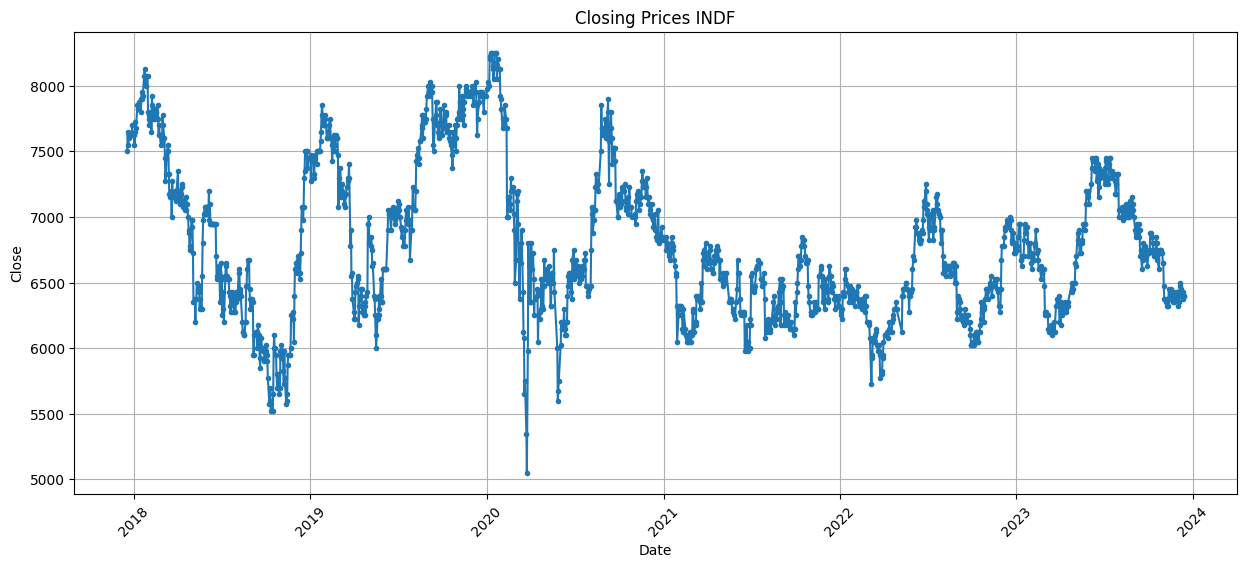

In [8]:
specific_df['Date'] = pd.to_datetime(specific_df['Date'])

plt.figure(figsize=(15,6))
plt.plot(specific_df['Date'], specific_df['Close'], marker='.')
plt.title('Closing Prices INDF')
plt.xlabel('Date')
plt.ylabel('Close')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

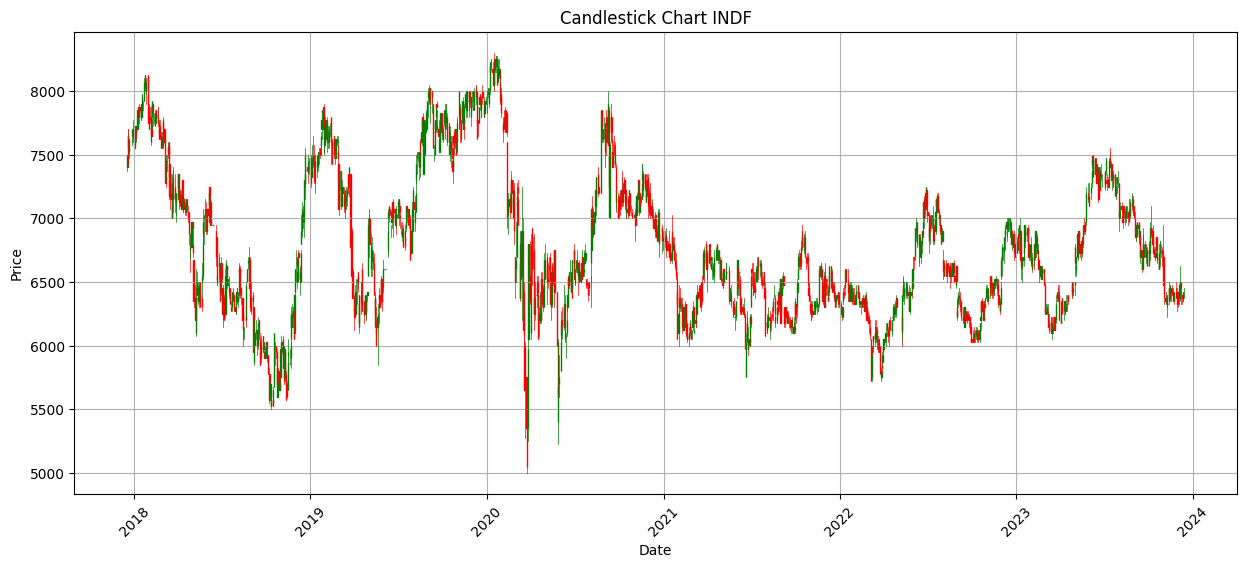

In [9]:
matplotlib_date = mdates.date2num(specific_df['Date'])

ohlc = np.vstack((matplotlib_date, specific_df['Open'], specific_df['High'], specific_df['Low'], specific_df['Close'])).T

plt.figure(figsize=(15,6))
ax = plt.subplot()
candlestick_ohlc(ax, ohlc, width=0.6, colorup='g', colordown='r')
ax.xaxis_date()
plt.title('Candlestick Chart INDF')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

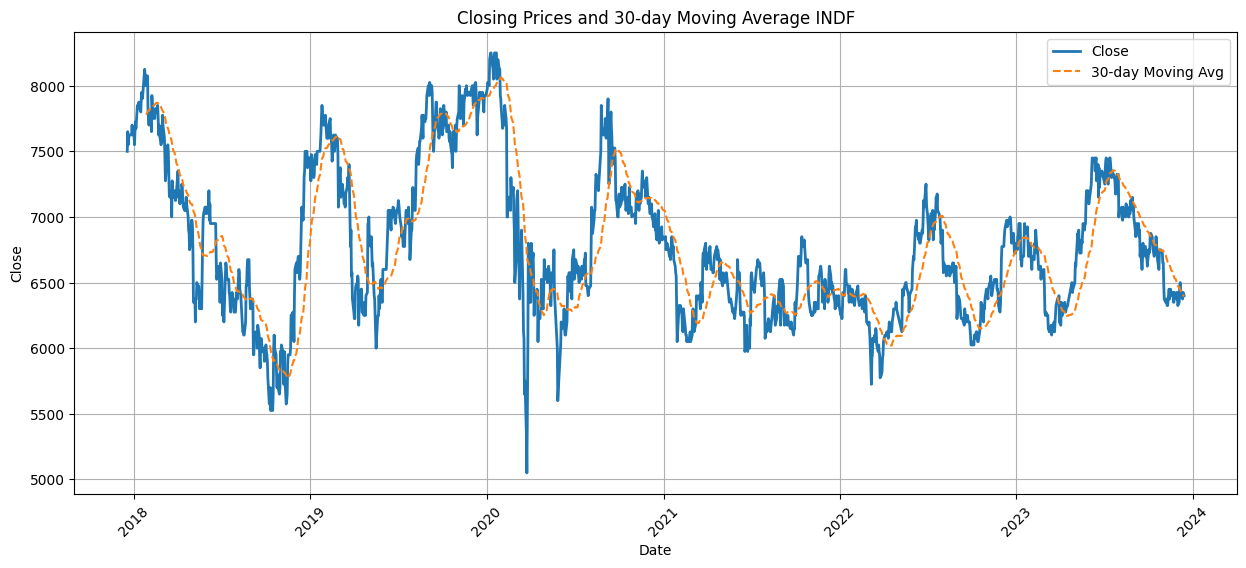

In [10]:
window = 30
plt.figure(figsize=(15,6))
plt.plot(specific_df['Date'], specific_df['Close'], label='Close', linewidth=2)
plt.plot(specific_df['Date'], specific_df['Close'].rolling(window=window).mean(),label=f'{window}-day Moving Avg', linestyle='--')
plt.title(f'Closing Prices and {window}-day Moving Average INDF')
plt.xlabel('Date')
plt.ylabel('Close')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

In [11]:
specific_df.head()

,Date,Close,Open,High,Low
0,2017-12-18,7500.0,7400.0,7500.0,7375.0
1,2017-12-19,7650.0,7500.0,7700.0,7475.0
2,2017-12-20,7550.0,7650.0,7700.0,7425.0
3,2017-12-21,7600.0,7525.0,7600.0,7475.0
4,2017-12-22,7625.0,7600.0,7625.0,7575.0


In [12]:
new_df = specific_df.reset_index()['Close']

In [13]:
new_df

0       7500.0
1       7650.0
2       7550.0
3       7600.0
4       7625.0
         ...  
1489    6400.0
1490    6375.0
1491    6425.0
1492    6400.0
1493    6400.0
Name: Close, Length: 1494, dtype: float64

In [14]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(np.array(new_df).reshape(-1,1))

In [15]:
data = scaled_data

top_20_data = data[:20]
print(top_20_data)

[[0.765625 ]
 [0.8125   ]
 [0.78125  ]
 [0.796875 ]
 [0.8046875]
 [0.8046875]
 [0.8046875]
 [0.8046875]
 [0.828125 ]
 [0.8046875]
 [0.8046875]
 [0.78125  ]
 [0.8125   ]
 [0.8359375]
 [0.8203125]
 [0.875    ]
 [0.8671875]
 [0.8671875]
 [0.8828125]
 [0.875    ]]


Partisi Data

90%

In [116]:
train_size = int(len(scaled_data)*0.9) #90% for training
train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]

In [117]:
n_past = 60

X_train, y_train = [], []
for i in range(n_past, len(train_data)):
    X_train.append(train_data[i - n_past:i, 0])
    y_train.append(train_data[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

X_test, y_test = [], []
for i in range(n_past, len(test_data)):
    X_test.append(test_data[i - n_past:i, 0])
    y_test.append(test_data[i, 0])

X_test, y_test = np.array(X_test), np.array(y_test)

In [118]:
print("Training set size:-")
print(X_train.shape), print(y_train.shape)
print("\n")
print("Testing set size:-")
print(X_test.shape), print(y_test.shape)

Training set size:-
(1284, 60)
(1284,)


Testing set size:-
(90, 60)
(90,)


(None, None)

In [119]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1],1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],1)

In [120]:
Layer = 3

In [121]:
model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
model.add(Dropout(0.9))

model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.9))

model.add(LSTM(units=50))
model.add(Dropout(0.9))

model.add(Dense(units=1))

In [122]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 60, 50)            10400     
                                                                 
 dropout_12 (Dropout)        (None, 60, 50)            0         
                                                                 
 lstm_13 (LSTM)              (None, 60, 50)            20200     
                                                                 
 dropout_13 (Dropout)        (None, 60, 50)            0         
                                                                 
 lstm_14 (LSTM)              (None, 50)                20200     
                                                                 
 dropout_14 (Dropout)        (None, 50)                0         
                                                                 
 dense_4 (Dense)             (None, 1)                

In [123]:
model.compile(loss='mean_squared_error',optimizer='adam')

In [124]:
checkpoints = ModelCheckpoint(filepath= 'indf.h5', save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

model.fit(X_train,y_train,
          validation_data=(X_test,y_test),
          epochs=100,
          batch_size=32,
          verbose=1,
          callbacks=[checkpoints,early_stopping])

Epoch 1/100
41/41 [==============================] - 21s 173ms/step - loss: 0.1513 - val_loss: 0.0090
Epoch 2/100
41/41 [==============================] - 3s 73ms/step - loss: 0.0801 - val_loss: 0.0078
Epoch 3/100
41/41 [==============================] - 3s 69ms/step - loss: 0.0660 - val_loss: 0.0122
Epoch 4/100
41/41 [==============================] - 3s 73ms/step - loss: 0.0588 - val_loss: 0.0064
Epoch 5/100
41/41 [==============================] - 3s 72ms/step - loss: 0.0540 - val_loss: 0.0032
Epoch 6/100
41/41 [==============================] - 3s 69ms/step - loss: 0.0446 - val_loss: 0.0027
Epoch 7/100
41/41 [==============================] - 3s 80ms/step - loss: 0.0417 - val_loss: 0.0018
Epoch 8/100
41/41 [==============================] - 3s 69ms/step - loss: 0.0352 - val_loss: 0.0040
Epoch 9/100
41/41 [==============================] - 3s 71ms/step - loss: 0.0334 - val_loss: 0.0014
Epoch 10/100
41/41 [==============================] - 3s 71ms/step - loss: 0.0315 - val_loss: 0.00

In [125]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

3/3 [==============================] - 0s 20ms/step


In [126]:
#train_predict=scaler.inverse_transform(train_predict)
#test_predict=scaler.inverse_transform(test_predict)


In [127]:
print(math.sqrt(mean_squared_error(y_train,train_predict)))
print(math.sqrt(mean_squared_error(y_test,test_predict)))

0.06901594712063185
0.03228887799829869


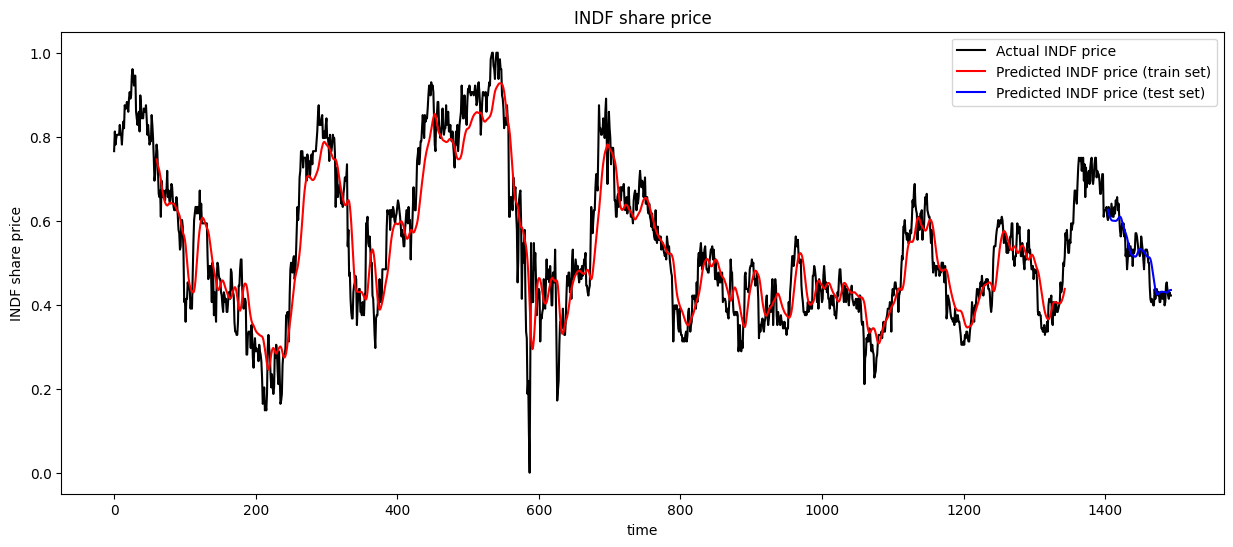

In [128]:
look_back = 60

trainPredictPlot = np.empty_like(new_df)
trainPredictPlot[:]= np.nan
trainPredictPlot[look_back:len(train_predict)+look_back]= train_predict.flatten()

testPredictPlot = np.empty_like(new_df)
testPredictPlot[:] = np.nan
test_start = len(new_df) - len(test_predict)
testPredictPlot[test_start:]= test_predict.flatten()

plt.figure(figsize=(15,6))
plt.plot(scaled_data, color='black', label=f"Actual INDF price")
plt.plot(trainPredictPlot, color='red', label=f"Predicted INDF price (train set)")
plt.plot(testPredictPlot, color='blue', label=f"Predicted INDF price (test set)")

plt.title(f"INDF share price")
plt.xlabel("time")
plt.ylabel(f"INDF share price")
plt.legend()
plt.show()

In [129]:
last_sequence = X_test[-1]
last_sequence = last_sequence.reshape(1, n_past, 1)

prediction_next_30_days = []

for _ in range(30):
    next_day_prediction = model.predict(last_sequence)
    prediction_next_30_days.append(next_day_prediction[0, 0])
    last_sequence = np.roll(last_sequence, -1, axis=1)
    last_sequence[0, -1, 0] = next_day_prediction

prediction_next_30_days = scaler.inverse_transform(np.array(prediction_next_30_days).reshape(-1, 1))

print("Predictions for the next 30 days:")
for i, prediction in enumerate(prediction_next_30_days, start=1):
    print(f"Day {i}: Predicted Price = {prediction[0]}")


1/1 [==============================] - 0s 31ms/step
Predictions for the next 30 days:
Day 1: Predicted Price = 6442.193359375
Day 2: Predicted Price = 6442.4814453125
Day 3: Predicted Price = 6443.19287109375
Day 4: Predicted Price = 6444.58544921875
Day 5: Predicted Price = 6446.6337890625
Day 6: Predicted Price = 6449.18212890625
Day 7: Predicted Price = 6452.03955078125
Day 8: Predicted Price = 6455.03759765625
Day 9: Predicted Price = 6458.052734375
Day 10: Predicted Price = 6461.00390625
Day 11: Predicted Price = 6463.8486328125
Day 12: Predicted Price = 6466.57275390625
Day 13: Predicted Price = 6469.1728515625
Day 14: Predicted Price = 6471.658203125
Day 15: Predicted Price = 6474.03857421875
Day 16: Predicted Price = 6476.32421875
Day 17: Predicted Price = 6478.52490234375
Day 18: Predicted Price = 6480.6455078125
Day 19: Predicted Price = 6482.693359375
Day 20: Predicted Price = 6484.67041015625
Day 21: Predicted Price = 6486.58154296875
Day 22: Predicted Price = 6488.42871093

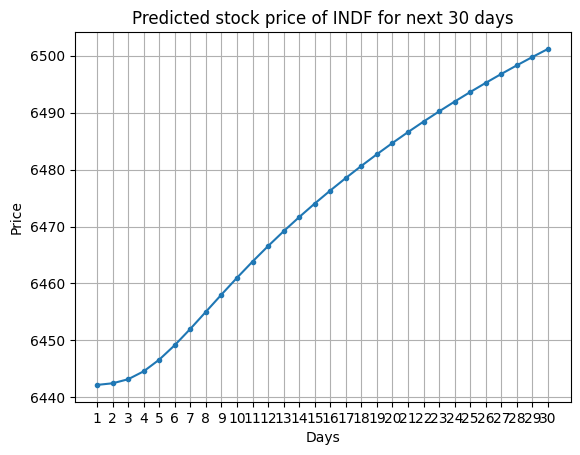

In [130]:
plt.plot(prediction_next_30_days, marker='.')
plt.title(f'Predicted stock price of INDF for next 30 days')
plt.xlabel('Days')
plt.ylabel('Price')
plt.xticks(range(0, 30), ['1','2','3','4','5','6','7','8','9','10',
                          '11','12','13','14','15','16','17','18','19','20',
                          '21','22','23','24','25','26','27','28','29','30'])
plt.grid(True)
plt.show()

In [131]:
# Evaluasi model
val_loss = model.evaluate(X_test, y_test)

print(f'Validation Loss: {val_loss}')

# Jika Anda memerlukan nilai MSE juga
val_mse = val_loss  # karena val_loss langsung berisi MSE
print(f'Validation MSE Loss: {val_mse}')



3/3 [==============================] - 0s 16ms/step - loss: 0.0010
Validation Loss: 0.0010425716172903776
Validation MSE Loss: 0.0010425716172903776


In [132]:
# Menghitung dan mencetak RMSE untuk data latih
train_rmse = np.sqrt(mean_squared_error(y_train, train_predict))
print(f'Training RMSE: {train_rmse}')

# Menghitung dan mencetak RMSE untuk data uji
test_rmse = np.sqrt(mean_squared_error(y_test, test_predict))
print(f'Testing RMSE: {test_rmse}')

Training RMSE: 0.06901594712063185
Testing RMSE: 0.03228887799829869


80%

In [133]:
train_size = int(len(scaled_data)*0.8) #80% for training
train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]

In [134]:
n_past = 60

X_train, y_train = [], []
for i in range(n_past, len(train_data)):
    X_train.append(train_data[i - n_past:i, 0])
    y_train.append(train_data[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

X_test, y_test = [], []
for i in range(n_past, len(test_data)):
    X_test.append(test_data[i - n_past:i, 0])
    y_test.append(test_data[i, 0])

X_test, y_test = np.array(X_test), np.array(y_test)

In [135]:
print("Training set size:-")
print(X_train.shape), print(y_train.shape)
print("\n")
print("Testing set size:-")
print(X_test.shape), print(y_test.shape)

Training set size:-
(1135, 60)
(1135,)


Testing set size:-
(239, 60)
(239,)


(None, None)

In [136]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1],1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],1)

In [137]:
Layer = 3

In [138]:
model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
model.add(Dropout(0.9))

model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.9))

model.add(LSTM(units=50))
model.add(Dropout(0.9))

model.add(Dense(units=1))

In [139]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_15 (LSTM)              (None, 60, 50)            10400     
                                                                 
 dropout_15 (Dropout)        (None, 60, 50)            0         
                                                                 
 lstm_16 (LSTM)              (None, 60, 50)            20200     
                                                                 
 dropout_16 (Dropout)        (None, 60, 50)            0         
                                                                 
 lstm_17 (LSTM)              (None, 50)                20200     
                                                                 
 dropout_17 (Dropout)        (None, 50)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                

In [140]:
model.compile(loss='mean_squared_error',optimizer='adam')

In [141]:
checkpoints = ModelCheckpoint(filepath= 'indf.h5', save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

model.fit(X_train,y_train,
          validation_data=(X_test,y_test),
          epochs=100,
          batch_size=32,
          verbose=1,
          callbacks=[checkpoints,early_stopping])

Epoch 1/100
36/36 [==============================] - 10s 97ms/step - loss: 0.1665 - val_loss: 0.0172
Epoch 2/100
36/36 [==============================] - 2s 62ms/step - loss: 0.0855 - val_loss: 0.0088
Epoch 3/100
36/36 [==============================] - 2s 59ms/step - loss: 0.0680 - val_loss: 0.0055
Epoch 4/100
36/36 [==============================] - 2s 59ms/step - loss: 0.0647 - val_loss: 0.0121
Epoch 5/100
36/36 [==============================] - 2s 60ms/step - loss: 0.0532 - val_loss: 0.0114
Epoch 6/100
36/36 [==============================] - 2s 59ms/step - loss: 0.0488 - val_loss: 0.0135
Epoch 7/100
36/36 [==============================] - 2s 58ms/step - loss: 0.0456 - val_loss: 0.0148
Epoch 8/100
36/36 [==============================] - 2s 61ms/step - loss: 0.0411 - val_loss: 0.0057
Epoch 9/100
36/36 [==============================] - 2s 61ms/step - loss: 0.0372 - val_loss: 0.0058
Epoch 10/100
36/36 [==============================] - 2s 66ms/step - loss: 0.0364 - val_loss: 0.008

In [142]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

8/8 [==============================] - 0s 21ms/step


In [143]:
#train_predict=scaler.inverse_transform(train_predict)
#test_predict=scaler.inverse_transform(test_predict)


In [144]:
print(math.sqrt(mean_squared_error(y_train,train_predict)))
print(math.sqrt(mean_squared_error(y_test,test_predict)))

0.07256858008616654
0.04495656049635251


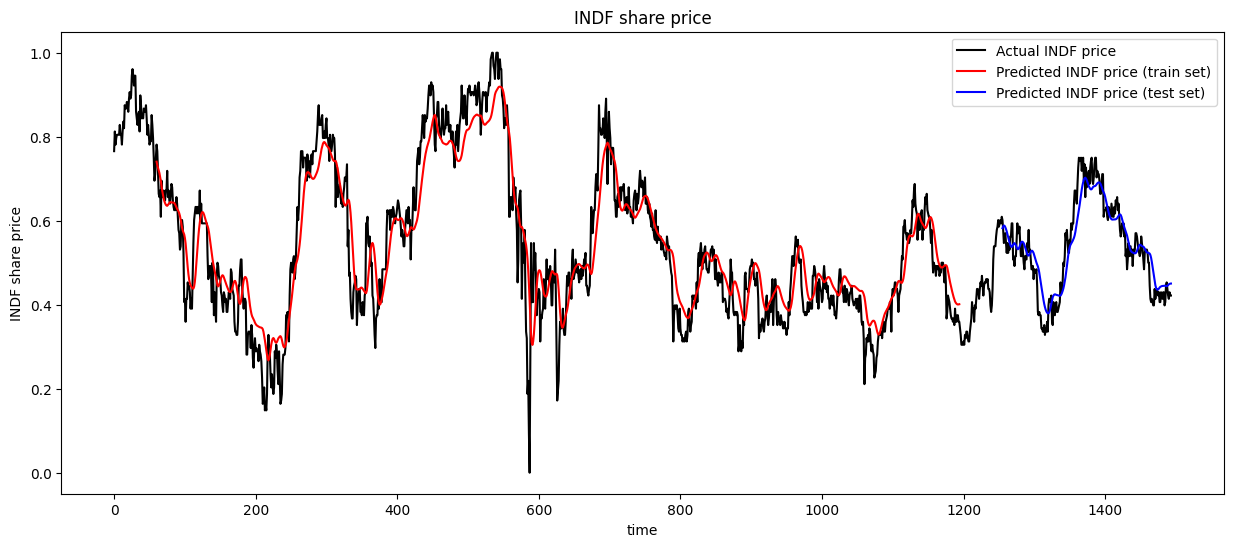

In [145]:
look_back = 60

trainPredictPlot = np.empty_like(new_df)
trainPredictPlot[:]= np.nan
trainPredictPlot[look_back:len(train_predict)+look_back]= train_predict.flatten()

testPredictPlot = np.empty_like(new_df)
testPredictPlot[:] = np.nan
test_start = len(new_df) - len(test_predict)
testPredictPlot[test_start:]= test_predict.flatten()

plt.figure(figsize=(15,6))
plt.plot(scaled_data, color='black', label=f"Actual INDF price")
plt.plot(trainPredictPlot, color='red', label=f"Predicted INDF price (train set)")
plt.plot(testPredictPlot, color='blue', label=f"Predicted INDF price (test set)")

plt.title(f"INDF share price")
plt.xlabel("time")
plt.ylabel(f"INDF share price")
plt.legend()
plt.show()

In [146]:
last_sequence = X_test[-1]
last_sequence = last_sequence.reshape(1, n_past, 1)

prediction_next_30_days = []

for _ in range(30):
    next_day_prediction = model.predict(last_sequence)
    prediction_next_30_days.append(next_day_prediction[0, 0])
    last_sequence = np.roll(last_sequence, -1, axis=1)
    last_sequence[0, -1, 0] = next_day_prediction

prediction_next_30_days = scaler.inverse_transform(np.array(prediction_next_30_days).reshape(-1, 1))

print("Predictions for the next 30 days:")
for i, prediction in enumerate(prediction_next_30_days, start=1):
    print(f"Day {i}: Predicted Price = {prediction[0]}")


1/1 [==============================] - 0s 32ms/step
Predictions for the next 30 days:
Day 1: Predicted Price = 6491.28955078125
Day 2: Predicted Price = 6492.994140625
Day 3: Predicted Price = 6496.94287109375
Day 4: Predicted Price = 6503.10205078125
Day 5: Predicted Price = 6510.97802734375
Day 6: Predicted Price = 6519.962890625
Day 7: Predicted Price = 6529.5087890625
Day 8: Predicted Price = 6539.19140625
Day 9: Predicted Price = 6548.72607421875
Day 10: Predicted Price = 6557.9404296875
Day 11: Predicted Price = 6566.748046875
Day 12: Predicted Price = 6575.11669921875
Day 13: Predicted Price = 6583.048828125
Day 14: Predicted Price = 6590.5625
Day 15: Predicted Price = 6597.68310546875
Day 16: Predicted Price = 6604.4375
Day 17: Predicted Price = 6610.8505859375
Day 18: Predicted Price = 6616.9443359375
Day 19: Predicted Price = 6622.73876953125
Day 20: Predicted Price = 6628.25146484375
Day 21: Predicted Price = 6633.4990234375
Day 22: Predicted Price = 6638.49658203125
Day 23:

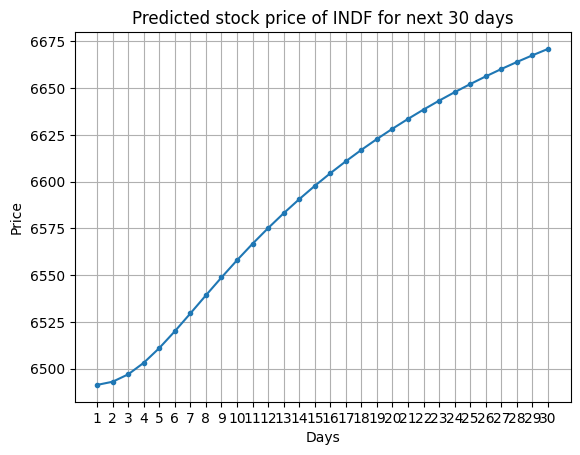

In [147]:
plt.plot(prediction_next_30_days, marker='.')
plt.title(f'Predicted stock price of INDF for next 30 days')
plt.xlabel('Days')
plt.ylabel('Price')
plt.xticks(range(0, 30), ['1','2','3','4','5','6','7','8','9','10',
                          '11','12','13','14','15','16','17','18','19','20',
                          '21','22','23','24','25','26','27','28','29','30'])
plt.grid(True)
plt.show()

In [148]:
# Evaluasi model
val_loss = model.evaluate(X_test, y_test)

print(f'Validation Loss: {val_loss}')

# Jika Anda memerlukan nilai MSE juga
val_mse = val_loss  # karena val_loss langsung berisi MSE
print(f'Validation MSE Loss: {val_mse}')



8/8 [==============================] - 0s 21ms/step - loss: 0.0020
Validation Loss: 0.0020210924558341503
Validation MSE Loss: 0.0020210924558341503


In [149]:
# Menghitung dan mencetak RMSE untuk data latih
train_rmse = np.sqrt(mean_squared_error(y_train, train_predict))
print(f'Training RMSE: {train_rmse}')

# Menghitung dan mencetak RMSE untuk data uji
test_rmse = np.sqrt(mean_squared_error(y_test, test_predict))
print(f'Testing RMSE: {test_rmse}')

Training RMSE: 0.07256858008616654
Testing RMSE: 0.04495656049635251


70%

In [150]:
train_size = int(len(scaled_data)*0.7) #70% for training
train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]

In [151]:
n_past = 60

X_train, y_train = [], []
for i in range(n_past, len(train_data)):
    X_train.append(train_data[i - n_past:i, 0])
    y_train.append(train_data[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

X_test, y_test = [], []
for i in range(n_past, len(test_data)):
    X_test.append(test_data[i - n_past:i, 0])
    y_test.append(test_data[i, 0])

X_test, y_test = np.array(X_test), np.array(y_test)

In [152]:
print("Training set size:-")
print(X_train.shape), print(y_train.shape)
print("\n")
print("Testing set size:-")
print(X_test.shape), print(y_test.shape)

Training set size:-
(985, 60)
(985,)


Testing set size:-
(389, 60)
(389,)


(None, None)

In [153]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1],1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],1)

In [154]:
Layer = 3

In [155]:
model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
model.add(Dropout(0.9))

model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.9))

model.add(LSTM(units=50))
model.add(Dropout(0.9))

model.add(Dense(units=1))

In [156]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_18 (LSTM)              (None, 60, 50)            10400     
                                                                 
 dropout_18 (Dropout)        (None, 60, 50)            0         
                                                                 
 lstm_19 (LSTM)              (None, 60, 50)            20200     
                                                                 
 dropout_19 (Dropout)        (None, 60, 50)            0         
                                                                 
 lstm_20 (LSTM)              (None, 50)                20200     
                                                                 
 dropout_20 (Dropout)        (None, 50)                0         
                                                                 
 dense_6 (Dense)             (None, 1)                

In [157]:
model.compile(loss='mean_squared_error',optimizer='adam')

In [158]:
checkpoints = ModelCheckpoint(filepath= 'indf.h5', save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

model.fit(X_train,y_train,
          validation_data=(X_test,y_test),
          epochs=100,
          batch_size=32,
          verbose=1,
          callbacks=[checkpoints,early_stopping])

Epoch 1/100
31/31 [==============================] - 10s 109ms/step - loss: 0.1612 - val_loss: 0.0120
Epoch 2/100
31/31 [==============================] - 2s 61ms/step - loss: 0.0901 - val_loss: 0.0090
Epoch 3/100
31/31 [==============================] - 2s 68ms/step - loss: 0.0706 - val_loss: 0.0083
Epoch 4/100
31/31 [==============================] - 2s 64ms/step - loss: 0.0679 - val_loss: 0.0157
Epoch 5/100
31/31 [==============================] - 2s 55ms/step - loss: 0.0642 - val_loss: 0.0075
Epoch 6/100
31/31 [==============================] - 2s 56ms/step - loss: 0.0568 - val_loss: 0.0071
Epoch 7/100
31/31 [==============================] - 2s 59ms/step - loss: 0.0482 - val_loss: 0.0096
Epoch 8/100
31/31 [==============================] - 2s 62ms/step - loss: 0.0478 - val_loss: 0.0106
Epoch 9/100
31/31 [==============================] - 2s 61ms/step - loss: 0.0463 - val_loss: 0.0050
Epoch 10/100
31/31 [==============================] - 2s 67ms/step - loss: 0.0394 - val_loss: 0.01

In [159]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

13/13 [==============================] - 0s 21ms/step


In [160]:
#train_predict=scaler.inverse_transform(train_predict)
#test_predict=scaler.inverse_transform(test_predict)


In [161]:
print(math.sqrt(mean_squared_error(y_train,train_predict)))
print(math.sqrt(mean_squared_error(y_test,test_predict)))

0.07772536093721542
0.04893485389797635


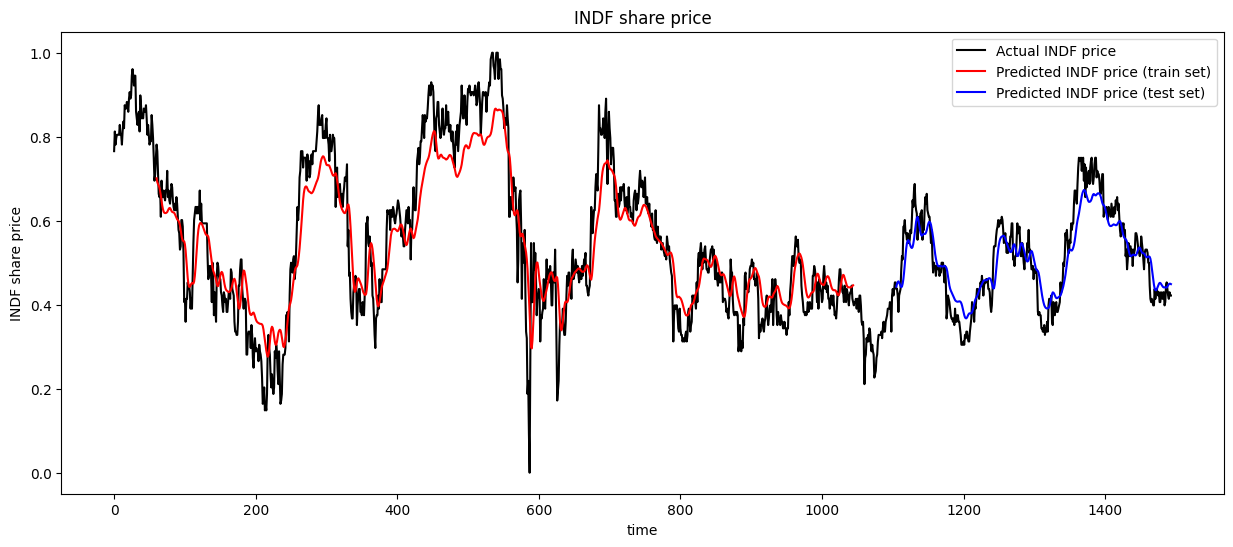

In [162]:
look_back = 60

trainPredictPlot = np.empty_like(new_df)
trainPredictPlot[:]= np.nan
trainPredictPlot[look_back:len(train_predict)+look_back]= train_predict.flatten()

testPredictPlot = np.empty_like(new_df)
testPredictPlot[:] = np.nan
test_start = len(new_df) - len(test_predict)
testPredictPlot[test_start:]= test_predict.flatten()

plt.figure(figsize=(15,6))
plt.plot(scaled_data, color='black', label=f"Actual INDF price")
plt.plot(trainPredictPlot, color='red', label=f"Predicted INDF price (train set)")
plt.plot(testPredictPlot, color='blue', label=f"Predicted INDF price (test set)")

plt.title(f"INDF share price")
plt.xlabel("time")
plt.ylabel(f"INDF share price")
plt.legend()
plt.show()

In [163]:
last_sequence = X_test[-1]
last_sequence = last_sequence.reshape(1, n_past, 1)

prediction_next_30_days = []

for _ in range(30):
    next_day_prediction = model.predict(last_sequence)
    prediction_next_30_days.append(next_day_prediction[0, 0])
    last_sequence = np.roll(last_sequence, -1, axis=1)
    last_sequence[0, -1, 0] = next_day_prediction

prediction_next_30_days = scaler.inverse_transform(np.array(prediction_next_30_days).reshape(-1, 1))

print("Predictions for the next 30 days:")
for i, prediction in enumerate(prediction_next_30_days, start=1):
    print(f"Day {i}: Predicted Price = {prediction[0]}")


1/1 [==============================] - 0s 107ms/step
Predictions for the next 30 days:
Day 1: Predicted Price = 6486.98974609375
Day 2: Predicted Price = 6485.65283203125
Day 3: Predicted Price = 6487.978515625
Day 4: Predicted Price = 6493.9287109375
Day 5: Predicted Price = 6502.44384765625
Day 6: Predicted Price = 6512.19580078125
Day 7: Predicted Price = 6522.0458984375
Day 8: Predicted Price = 6531.2392578125
Day 9: Predicted Price = 6539.40576171875
Day 10: Predicted Price = 6546.47998046875
Day 11: Predicted Price = 6552.57275390625
Day 12: Predicted Price = 6557.87646484375
Day 13: Predicted Price = 6562.58837890625
Day 14: Predicted Price = 6566.87158203125
Day 15: Predicted Price = 6570.841796875
Day 16: Predicted Price = 6574.56982421875
Day 17: Predicted Price = 6578.09521484375
Day 18: Predicted Price = 6581.4345703125
Day 19: Predicted Price = 6584.59619140625
Day 20: Predicted Price = 6587.5810546875
Day 21: Predicted Price = 6590.39306640625
Day 22: Predicted Price = 65

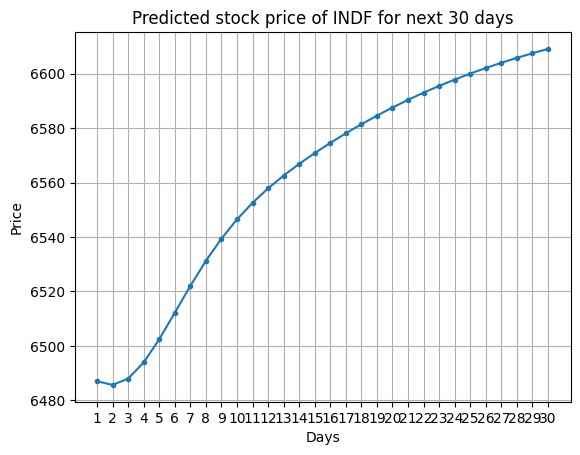

In [164]:
plt.plot(prediction_next_30_days, marker='.')
plt.title(f'Predicted stock price of INDF for next 30 days')
plt.xlabel('Days')
plt.ylabel('Price')
plt.xticks(range(0, 30), ['1','2','3','4','5','6','7','8','9','10',
                          '11','12','13','14','15','16','17','18','19','20',
                          '21','22','23','24','25','26','27','28','29','30'])
plt.grid(True)
plt.show()

In [165]:
# Evaluasi model
val_loss = model.evaluate(X_test, y_test)

print(f'Validation Loss: {val_loss}')

# Jika Anda memerlukan nilai MSE juga
val_mse = val_loss  # karena val_loss langsung berisi MSE
print(f'Validation MSE Loss: {val_mse}')



13/13 [==============================] - 0s 23ms/step - loss: 0.0024
Validation Loss: 0.0023946198634803295
Validation MSE Loss: 0.0023946198634803295


In [166]:
# Menghitung dan mencetak RMSE untuk data latih
train_rmse = np.sqrt(mean_squared_error(y_train, train_predict))
print(f'Training RMSE: {train_rmse}')

# Menghitung dan mencetak RMSE untuk data uji
test_rmse = np.sqrt(mean_squared_error(y_test, test_predict))
print(f'Testing RMSE: {test_rmse}')

Training RMSE: 0.07772536093721542
Testing RMSE: 0.04893485389797635


60%

In [167]:
train_size = int(len(scaled_data)*0.6) #60% for training
train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]

In [168]:
n_past = 60

X_train, y_train = [], []
for i in range(n_past, len(train_data)):
    X_train.append(train_data[i - n_past:i, 0])
    y_train.append(train_data[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

X_test, y_test = [], []
for i in range(n_past, len(test_data)):
    X_test.append(test_data[i - n_past:i, 0])
    y_test.append(test_data[i, 0])

X_test, y_test = np.array(X_test), np.array(y_test)

In [169]:
print("Training set size:-")
print(X_train.shape), print(y_train.shape)
print("\n")
print("Testing set size:-")
print(X_test.shape), print(y_test.shape)

Training set size:-
(836, 60)
(836,)


Testing set size:-
(538, 60)
(538,)


(None, None)

In [170]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1],1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],1)

In [171]:
Layer = 3

In [172]:
model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
model.add(Dropout(0.9))

model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.9))

model.add(LSTM(units=50))
model.add(Dropout(0.9))

model.add(Dense(units=1))

In [173]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_21 (LSTM)              (None, 60, 50)            10400     
                                                                 
 dropout_21 (Dropout)        (None, 60, 50)            0         
                                                                 
 lstm_22 (LSTM)              (None, 60, 50)            20200     
                                                                 
 dropout_22 (Dropout)        (None, 60, 50)            0         
                                                                 
 lstm_23 (LSTM)              (None, 50)                20200     
                                                                 
 dropout_23 (Dropout)        (None, 50)                0         
                                                                 
 dense_7 (Dense)             (None, 1)                

In [174]:
model.compile(loss='mean_squared_error',optimizer='adam')

In [175]:
checkpoints = ModelCheckpoint(filepath= 'indf.h5', save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

model.fit(X_train,y_train,
          validation_data=(X_test,y_test),
          epochs=100,
          batch_size=32,
          verbose=1,
          callbacks=[checkpoints,early_stopping])

Epoch 1/100
27/27 [==============================] - 38s 334ms/step - loss: 0.1765 - val_loss: 0.0061
Epoch 2/100
27/27 [==============================] - 2s 88ms/step - loss: 0.1097 - val_loss: 0.0088
Epoch 3/100
27/27 [==============================] - 3s 96ms/step - loss: 0.0873 - val_loss: 0.0086
Epoch 4/100
27/27 [==============================] - 2s 84ms/step - loss: 0.0822 - val_loss: 0.0148
Epoch 5/100
27/27 [==============================] - 2s 87ms/step - loss: 0.0716 - val_loss: 0.0094
Epoch 6/100
27/27 [==============================] - 2s 86ms/step - loss: 0.0626 - val_loss: 0.0126
Epoch 7/100
27/27 [==============================] - 2s 87ms/step - loss: 0.0570 - val_loss: 0.0058
Epoch 8/100
27/27 [==============================] - 2s 93ms/step - loss: 0.0547 - val_loss: 0.0061
Epoch 9/100
27/27 [==============================] - 3s 104ms/step - loss: 0.0555 - val_loss: 0.0054
Epoch 10/100
27/27 [==============================] - 3s 104ms/step - loss: 0.0472 - val_loss: 0.

In [176]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

17/17 [==============================] - 0s 23ms/step


In [177]:
#train_predict=scaler.inverse_transform(train_predict)
#test_predict=scaler.inverse_transform(test_predict)


In [178]:
print(math.sqrt(mean_squared_error(y_train,train_predict)))
print(math.sqrt(mean_squared_error(y_test,test_predict)))

0.08135130812166926
0.056151933061619135


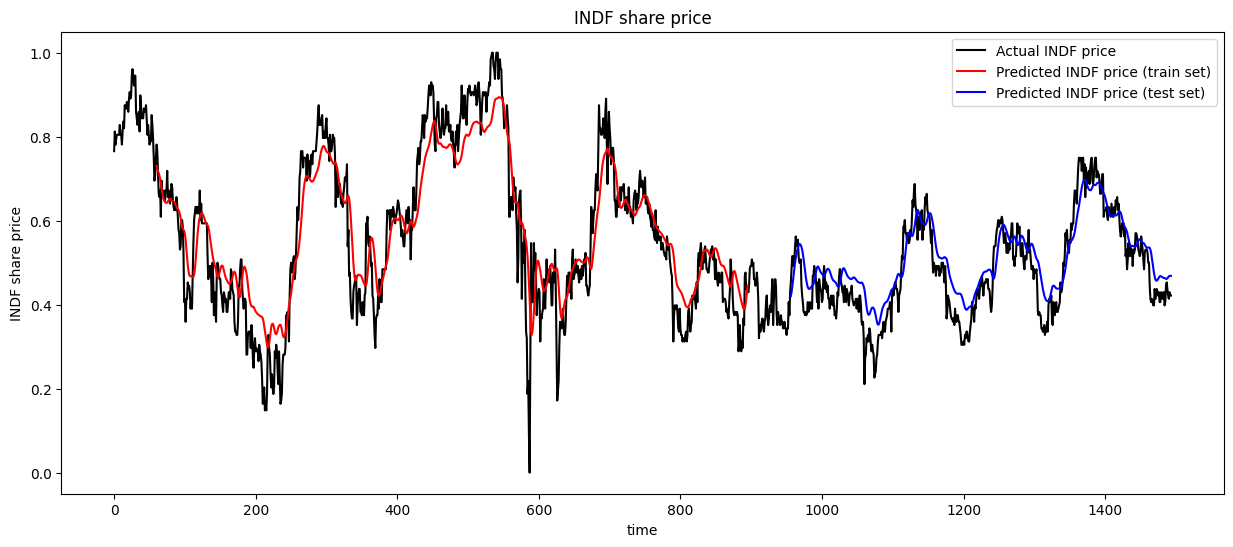

In [179]:
look_back = 60

trainPredictPlot = np.empty_like(new_df)
trainPredictPlot[:]= np.nan
trainPredictPlot[look_back:len(train_predict)+look_back]= train_predict.flatten()

testPredictPlot = np.empty_like(new_df)
testPredictPlot[:] = np.nan
test_start = len(new_df) - len(test_predict)
testPredictPlot[test_start:]= test_predict.flatten()

plt.figure(figsize=(15,6))
plt.plot(scaled_data, color='black', label=f"Actual INDF price")
plt.plot(trainPredictPlot, color='red', label=f"Predicted INDF price (train set)")
plt.plot(testPredictPlot, color='blue', label=f"Predicted INDF price (test set)")

plt.title(f"INDF share price")
plt.xlabel("time")
plt.ylabel(f"INDF share price")
plt.legend()
plt.show()

In [180]:
last_sequence = X_test[-1]
last_sequence = last_sequence.reshape(1, n_past, 1)

prediction_next_30_days = []

for _ in range(30):
    next_day_prediction = model.predict(last_sequence)
    prediction_next_30_days.append(next_day_prediction[0, 0])
    last_sequence = np.roll(last_sequence, -1, axis=1)
    last_sequence[0, -1, 0] = next_day_prediction

prediction_next_30_days = scaler.inverse_transform(np.array(prediction_next_30_days).reshape(-1, 1))

print("Predictions for the next 30 days:")
for i, prediction in enumerate(prediction_next_30_days, start=1):
    print(f"Day {i}: Predicted Price = {prediction[0]}")


1/1 [==============================] - 0s 111ms/step
Predictions for the next 30 days:
Day 1: Predicted Price = 6549.59814453125
Day 2: Predicted Price = 6552.35986328125
Day 3: Predicted Price = 6560.47509765625
Day 4: Predicted Price = 6573.2900390625
Day 5: Predicted Price = 6589.2158203125
Day 6: Predicted Price = 6606.59033203125
Day 7: Predicted Price = 6624.09228515625
Day 8: Predicted Price = 6640.86474609375
Day 9: Predicted Price = 6656.46728515625
Day 10: Predicted Price = 6670.76513671875
Day 11: Predicted Price = 6683.806640625
Day 12: Predicted Price = 6695.7314453125
Day 13: Predicted Price = 6706.703125
Day 14: Predicted Price = 6716.8740234375
Day 15: Predicted Price = 6726.36962890625
Day 16: Predicted Price = 6735.2861328125
Day 17: Predicted Price = 6743.6943359375
Day 18: Predicted Price = 6751.646484375
Day 19: Predicted Price = 6759.1796875
Day 20: Predicted Price = 6766.32470703125
Day 21: Predicted Price = 6773.10400390625
Day 22: Predicted Price = 6779.5395507

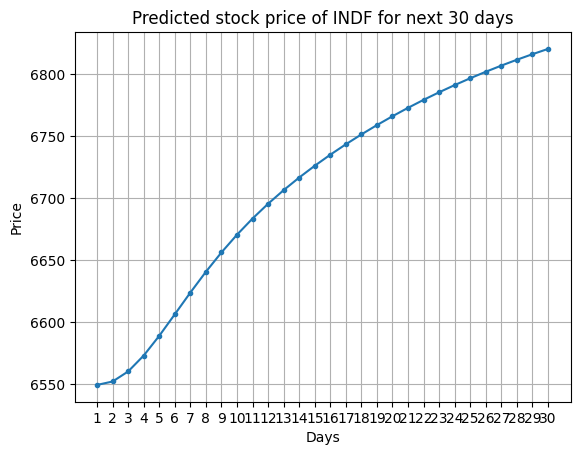

In [181]:
plt.plot(prediction_next_30_days, marker='.')
plt.title(f'Predicted stock price of INDF for next 30 days')
plt.xlabel('Days')
plt.ylabel('Price')
plt.xticks(range(0, 30), ['1','2','3','4','5','6','7','8','9','10',
                          '11','12','13','14','15','16','17','18','19','20',
                          '21','22','23','24','25','26','27','28','29','30'])
plt.grid(True)
plt.show()

In [182]:
# Evaluasi model
val_loss = model.evaluate(X_test, y_test)

print(f'Validation Loss: {val_loss}')

# Jika Anda memerlukan nilai MSE juga
val_mse = val_loss  # karena val_loss langsung berisi MSE
print(f'Validation MSE Loss: {val_mse}')



17/17 [==============================] - 0s 23ms/step - loss: 0.0032
Validation Loss: 0.003153039375320077
Validation MSE Loss: 0.003153039375320077


In [183]:
# Menghitung dan mencetak RMSE untuk data latih
train_rmse = np.sqrt(mean_squared_error(y_train, train_predict))
print(f'Training RMSE: {train_rmse}')

# Menghitung dan mencetak RMSE untuk data uji
test_rmse = np.sqrt(mean_squared_error(y_test, test_predict))
print(f'Testing RMSE: {test_rmse}')

Training RMSE: 0.08135130812166926
Testing RMSE: 0.056151933061619135


: 